# Calculate interaction using Genotype x Age model

In [1]:
setwd('/tscc/projects/ps-epigen/users/biy022/5XFAD_mouse/data/')

In [2]:
suppressPackageStartupMessages({
    library(Seurat)
    library(SeuratWrappers)
    library(patchwork)
    library(ggplot2)
    library(repr)
    library(gridExtra)
    library(edgeR)
    library(SingleCellExperiment)
    library(Matrix)
    library(scran)
    library(tidyverse)
    library(ggrepel)
    library(scater)
})
options(future.globals.maxSize = 1e9)
options(Seurat.object.assay.version = "v5")
options(ggrepel.max.overlaps = Inf)

In [3]:
curr.model <- readRDS("DGE_fit_genotype_age_models/Microglia.model")

In [4]:
colnames(curr.model)

[1] "WT.3M"  "AD.3M"  "WT.9M"  "AD.9M"  "WT.18M" "AD.18M"

In [5]:
contrasts.list <- makeContrasts(
    inter9Mvs3M = (AD.9M-WT.9M) - (AD.3M-WT.3M),
    inter18Mvs3M = (AD.18M-WT.18M) - (AD.3M-WT.3M),
    inter18Mvs9M = (AD.18M-WT.18M) - (AD.9M-WT.9M),
    levels = curr.model$design
)

In [6]:
contrast.names <- c(
    "inter9Mvs3M",
    "inter18Mvs3M",
    "inter18Mvs9M"
)

In [7]:
curr.glf <- glmQLFTest(curr.model, contrast = contrasts.list[, "inter18Mvs3M"])

In [8]:
model.names <- list.files("DGE_fit_genotype_age_models/")
celltype.list <- sapply(strsplit(model.names, split = "[.]"), `[`, 1)
celltype.list

[1] "Astro"          "CA1"            "CA2"            "CA3"           
 [5] "Cajal-Retzius"  "Chandelier"     "Choroid-plexus" "DG"            
 [9] "Endo"           "IOL"            "Lamp5"          "Meis2"         
[13] "Microglia"      "NB"             "Oligo"          "OPC"           
[17] "Pvalb"          "PVM"            "RGL"            "SMC-Peri"      
[21] "Sncg"           "Sst"            "SUB_1"          "SUB_2"         
[25] "SUB_3"          "SUB-ProS"       "Vip"            "VLMC"

In [9]:
for (celltype in celltype.list) {
    curr.model <- readRDS(file.path("DGE_fit_genotype_age_models/", paste0(celltype, ".model")))
    curr.output.dir <- file.path("DGE_contrasts_genotype_age_interaction/", celltype)
    if (!dir.exists(curr.output.dir)) {
        dir.create(curr.output.dir)
    }
    
    for (contrast in contrast.names) {
        curr.glf <- glmQLFTest(curr.model, contrast = contrasts.list[, contrast])
        write.table(
            topTags(curr.glf, n = Inf)$table, 
            file.path(curr.output.dir, paste0(contrast, ".", "tsv")), 
            row.names = TRUE,
            col.names = TRUE,
            quote = FALSE,
            sep = "\t"
        )
    }
}

## Check the test result

In [3]:
rna_object <- readRDS("Celltype_Seurat_Objects/Microglia.rds")

In [4]:
rna_object

An object of class Seurat 
32285 features across 40553 samples within 1 assay 
Active assay: RNA (32285 features, 4000 variable features)
 2 layers present: counts, data

In [5]:
rna_sce <- SingleCellExperiment(
    assay = list(counts = LayerData(rna_object, layer = c("counts"))),
    colData = rna_object@meta.data
)

In [6]:
rna_sce_aggr <- aggregateAcrossCells(rna_sce, ids = rna_sce$mouse_id)
cpm_matrix <- calculateCPM(rna_sce_aggr)
log2_cpm <- log2(cpm_matrix + 1)

In [7]:
rna_sce_aggr@colData$genotype_age <- paste(rna_sce_aggr$genotype, rna_sce_aggr$age, sep = "_")

In [8]:
group_order <- c(
    "WT_3M", "WT_9M", "WT_18M",
    "5XFAD_3M", "5XFAD_9M", "5XFAD_18M"
)

In [9]:
gene_list <- c(
    "Flt1", "Etl4", "Olfr111", "A430093F15Rik", "Csf1", "Neat1",
    "Lilrb4a", "Ctse", "Fam20c", "Bcar3", "Lpl", "Cd300lf"
)

In [10]:
plot_data <- data.frame(cbind(t(log2_cpm[gene_list, ]), rna_sce_aggr$genotype_age))
colnames(plot_data) <- c(gene_list, "group")
plot_data[, gene_list] <- sapply(plot_data[, gene_list], as.numeric)
plot_data$group <- factor(plot_data$group, levels = group_order)

In [11]:
plots <- lapply(1:length(gene_list), function(i) {
    plot_data |>
    ggplot(aes(x = group, y = !!sym(gene_list[i]))) +
    geom_boxplot() +
    labs(title = gene_list[i]) +
    #ylim(0, 20) +
    theme_classic() +
    theme(
        text = element_text(family = "mono", size = 17.5),
        axis.text.x = element_text(angle = 45, hjust = 1)
    )
})

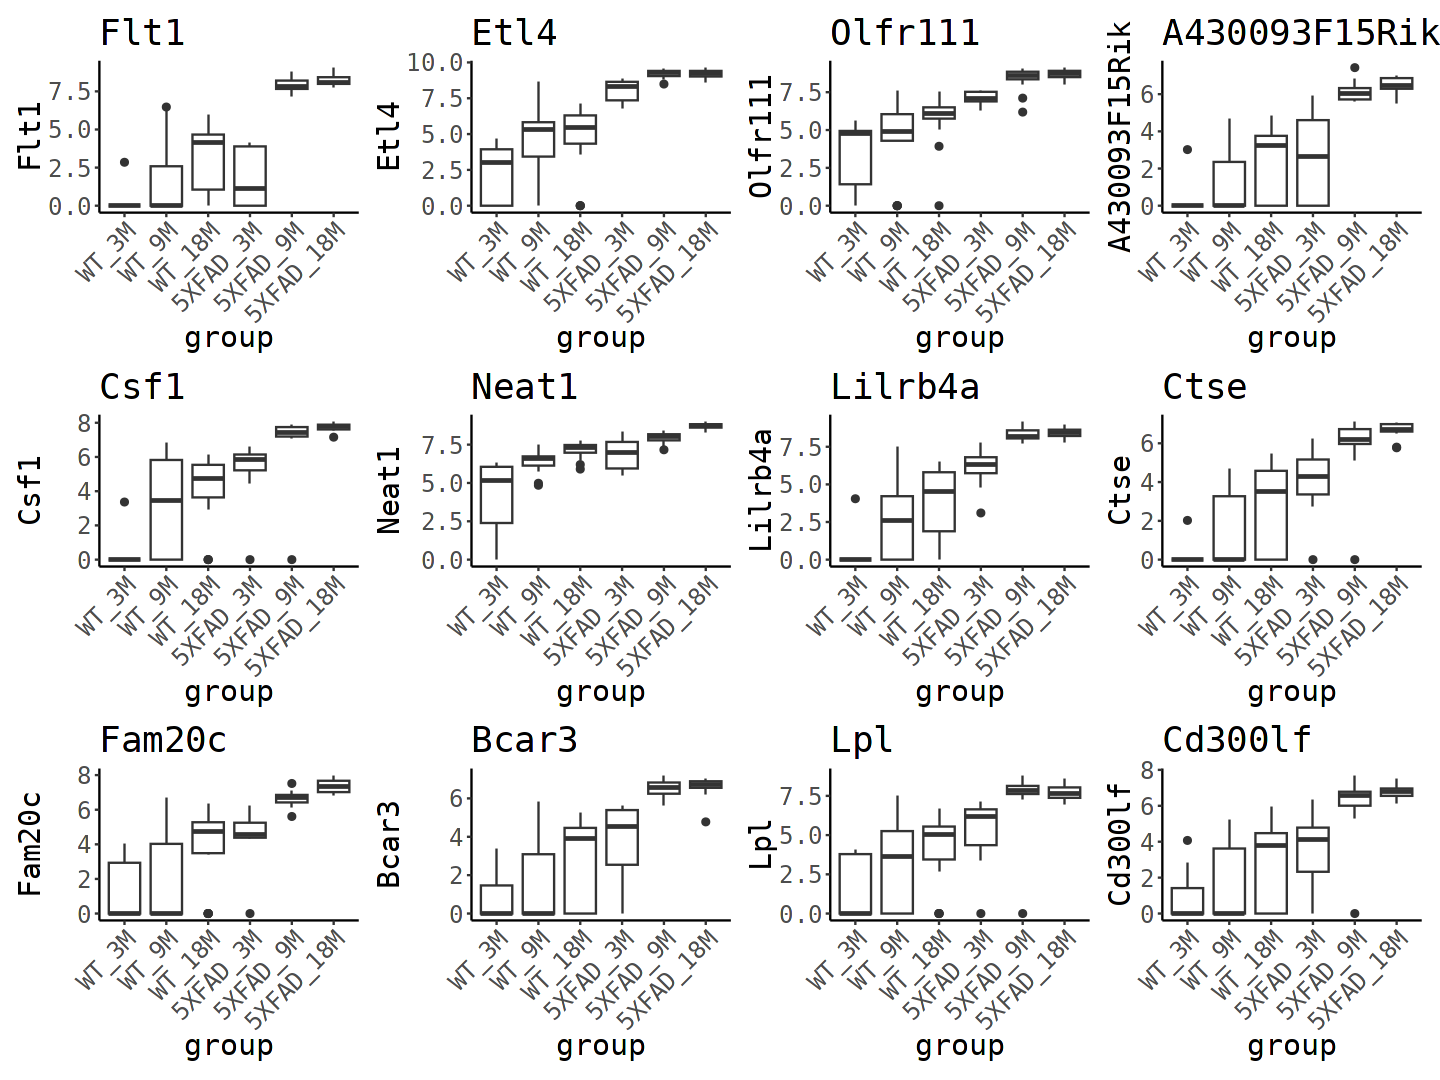

In [12]:
options(repr.plot.width = 12, repr.plot.height = 9)
wrap_plots(plots, ncol = 4, nrow = 3)

In [13]:
rna_sce@colData$genotype_age <- paste(rna_sce$genotype, rna_sce$age, sep = "_")

In [14]:
rna_sce_aggr_aggr <- aggregateAcrossCells(
    rna_sce,
    ids = rna_sce$genotype_age
)

In [15]:
rna_sce_aggr_aggr_cpm <- calculateCPM(rna_sce_aggr_aggr)
rna_sce_aggr_aggr_log2_cpm <- log2(rna_sce_aggr_aggr_cpm + 1)

In [16]:
expr_diff <- ((
    rna_sce_aggr_aggr_log2_cpm[, "5XFAD_18M"] -
    rna_sce_aggr_aggr_log2_cpm[, "WT_18M"]
) - 
(
    rna_sce_aggr_aggr_log2_cpm[, "5XFAD_3M"] -
    rna_sce_aggr_aggr_log2_cpm[, "WT_3M"]
))

In [17]:
micro_edger_result <- read.table(
    "DGE_contrasts_genotype_age_interaction/Microglia/inter18Mvs3M.tsv",
    sep = "\t", header = TRUE
)

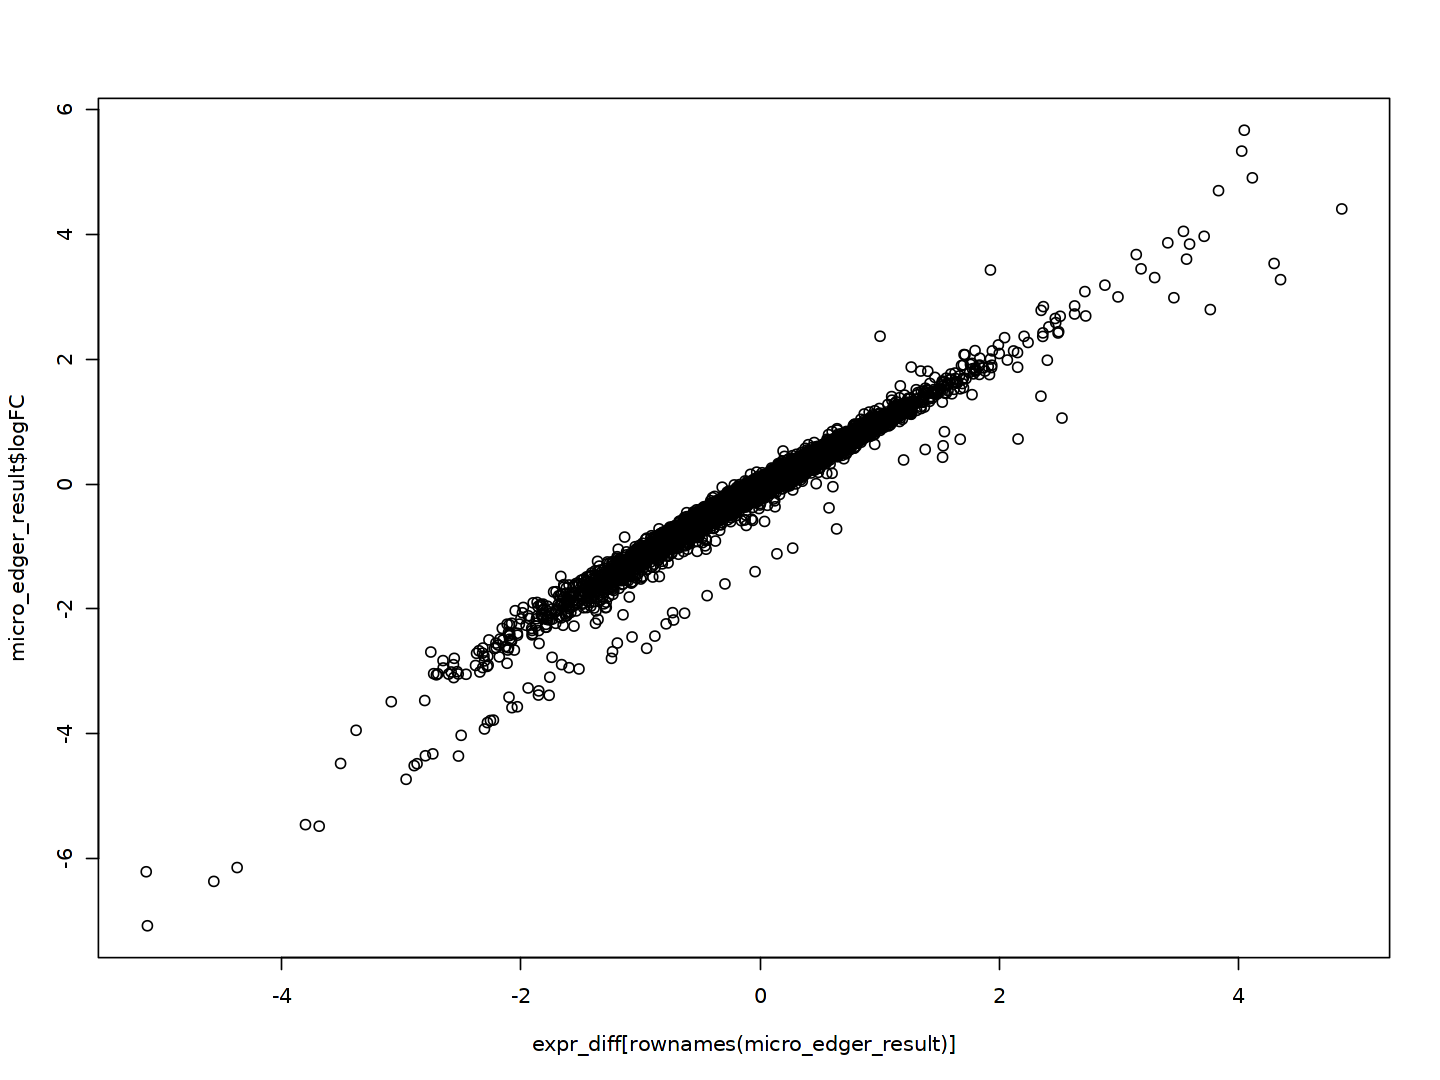

In [18]:
plot(
    expr_diff[rownames(micro_edger_result)],
    micro_edger_result$logFC
)

## Use simple linear regression model

In [3]:
model.names <- list.files("DGE_fit_genotype_age_models/")
celltype.list <- sapply(strsplit(model.names, split = "[.]"), `[`, 1)

for (celltype in celltype.list) {
    print(celltype)
    flush.console()
    rna_object_path <- sprintf("Celltype_Seurat_Objects/%s.rds", celltype)
    rna_object <- readRDS(rna_object_path)
    rna_sce <- SingleCellExperiment(
        assay = list(counts = LayerData(rna_object, layer = c("counts"))),
        colData = rna_object@meta.data
    )
    rna_sce_aggr <- aggregateAcrossCells(rna_sce, ids = rna_sce$mouse_id)
    cpm_matrix <- calculateCPM(rna_sce_aggr)
    log2_cpm <- log2(cpm_matrix + 1)
    
    curr_age_coef <- c()
    curr_age_p <- c()
    curr_inter_coef <- c()
    curr_inter_p <- c()
    for (i in 1:nrow(cpm_matrix)) {
        curr_df <- data.frame(
            expr = cpm_matrix[i, ],
            age = as.integer(gsub("M", "", rna_sce_aggr$age)),
            genotype = rna_sce_aggr$genotype
        )
        model <- lm(expr ~ age * genotype, data = curr_df)
        curr_age_coef <- c(curr_age_coef, coef(summary(model))["age", "Estimate"])
        curr_age_p <- c(curr_age_p, coef(summary(model))["age", "Pr(>|t|)"])
        curr_inter_coef <- c(curr_inter_coef, coef(summary(model))["age:genotype5XFAD", "Estimate"])
        curr_inter_p <- c(curr_inter_p, coef(summary(model))["age:genotype5XFAD", "Pr(>|t|)"])
    }
    curr_result_df <- data.frame(
        age_coef = curr_age_coef,
        age_pvalue = curr_age_p,
        interaction_coef = curr_inter_coef,
        interaction_pvalue = curr_inter_p
    )
    rownames(curr_result_df) <- rownames(cpm_matrix)
    
    write.table(
        curr_result_df,
        sprintf("DGE_genotype_age_interaction_simple_regression/%s.cpm.tsv", celltype),
        sep = "\t", row.names = TRUE, col.names = TRUE, quote = FALSE
    )
    
    curr_age_coef <- c()
    curr_age_p <- c()
    curr_inter_coef <- c()
    curr_inter_p <- c()
    for (i in 1:nrow(log2_cpm)) {
        curr_df <- data.frame(
            expr = log2_cpm[i, ],
            age = as.integer(gsub("M", "", rna_sce_aggr$age)),
            genotype = rna_sce_aggr$genotype
        )
        model <- lm(expr ~ age * genotype, data = curr_df)
        curr_age_coef <- c(curr_age_coef, coef(summary(model))["age", "Estimate"])
        curr_age_p <- c(curr_age_p, coef(summary(model))["age", "Pr(>|t|)"])
        curr_inter_coef <- c(curr_inter_coef, coef(summary(model))["age:genotype5XFAD", "Estimate"])
        curr_inter_p <- c(curr_inter_p, coef(summary(model))["age:genotype5XFAD", "Pr(>|t|)"])
    }
    curr_result_df <- data.frame(
        age_coef = curr_age_coef,
        age_pvalue = curr_age_p,
        interaction_coef = curr_inter_coef,
        interaction_pvalue = curr_inter_p
    )
    rownames(curr_result_df) <- rownames(log2_cpm)
    write.table(
        curr_result_df,
        sprintf("DGE_genotype_age_interaction_simple_regression/%s.log2cpm.tsv", celltype),
        sep = "\t", row.names = TRUE, col.names = TRUE, quote = FALSE
    )
}

[1] "Astro"
[1] "CA1"
[1] "CA2"
[1] "CA3"
[1] "Cajal-Retzius"
[1] "Chandelier"
[1] "Choroid-plexus"
[1] "DG"
[1] "Endo"
[1] "IOL"
[1] "Lamp5"
[1] "Meis2"
[1] "Microglia"
[1] "NB"
[1] "Oligo"
[1] "OPC"
[1] "Pvalb"
[1] "PVM"
[1] "RGL"
[1] "SMC-Peri"
[1] "Sncg"
[1] "Sst"
[1] "SUB_1"
[1] "SUB_2"
[1] "SUB_3"
[1] "SUB-ProS"
[1] "Vip"
[1] "VLMC"
